# Source Detection Benchmark

In [2]:
import numpy as np
from karabo.sourcedetection.evaluation import SourceDetectionEvaluation
import matplotlib.pyplot as plt

# Render matplotlib inline
%matplotlib inline

## Evaluation Measures

true positives (TP), false positives (FP) or false negatives (FN)
true sources correctly detected (TSD) = recall = TP / (TP + FN)
reliability = precision = TP / (TP + FP)

The strategy used to match the detections with the sources in the reference catalogue is the following: first, the closest detection for each source in the catalogue is found. Second, associations between sources and detections that are further away than a pre-established maximum distanceance are deleted. We assume that the centre of two different sources cannot be closer than the FWHM of the image, so this is the maximum distance selected. Next, where detections associated with more than one source from the catalogue are found, only the closest association is kept, deleting the others. In the same way, if a true source is associated with more than one detection, only the correspondence with the shortest distance is saved. Finally, the evaluation measures are computed: TP are the detections associated with a source, FP are detections without any associated source, while FN are sources with no associations with a detection (AUTOMATIC SOURCE DETECTION IN ASTRONOMICAL IMAGES, Marc MASIAS MOYSET 2014).

The implementation of `automatic_assignment` is pretty similar, but not equal. For details read the docstring.

In [15]:
# with this seed and max_dist it seems to be correct
max_dist = 0.5
gtruth = np.array([
    [0.0, 0.0],
    [1.1, 1.1],
    [2.2, 2.2],
    [3.3, 3.3],
    [4.4, 4.4],
    [5.5, 5.5],
    [6.6, 6.6],
    [7.7, 7.7],
])


# Flip gtruth to get a different result        
detection = np.flipud(gtruth) + np.random.randn(*gtruth.shape) * 0.1
detection = np.vstack((detection, np.array([-2, -2])))

print('Shape of ground truth: ', gtruth.shape)
print('Shape of detection: ', detection.shape)

Shape of ground truth:  (8, 2)
Shape of detection:  (9, 2)


In [19]:
assigment = SourceDetectionEvaluation.automatic_assignment_of_ground_truth_and_prediction(gtruth, detection, max_dist, top_k=3)
assigment

array([[0.        , 7.        , 0.01970411],
       [1.        , 6.        , 0.06513021],
       [2.        , 5.        , 0.15163152],
       [3.        , 4.        , 0.19893189],
       [4.        , 3.        , 0.12044694],
       [5.        , 2.        , 0.04297615],
       [6.        , 1.        , 0.29506571],
       [7.        , 0.        , 0.03955685]])

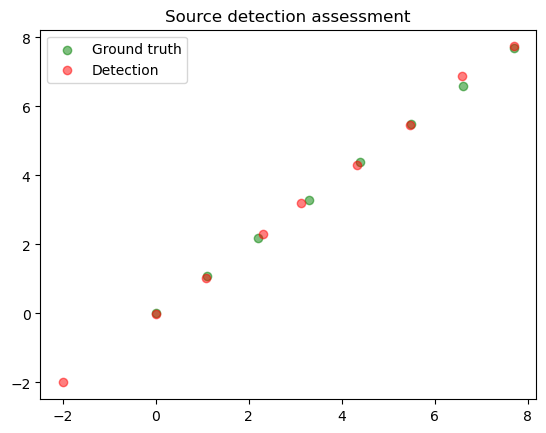

In [20]:
plt.scatter(gtruth[:,0], gtruth[:,1], c='g', alpha=0.5, label='ground truth')
plt.scatter(detection[:,0], detection[:,1], c='r', alpha=0.5, label='detection')
plt.legend(['Ground truth', 'Detection'])
plt.title('Source detection assessment')
plt.show()

## Calculate TP, FP, FN

In [21]:
SourceDetectionEvaluation.calculate_evaluation_measures(gtruth, detection, assigment)

(8, 0, 1)

## Test with bigger data

In [22]:
gtruth = np.random.randn(500000, 2) * 10
detected = np.flipud(gtruth)

result = SourceDetectionEvaluation.automatic_assignment_of_ground_truth_and_prediction(gtruth, detected, max_dist, top_k=3)

assert np.all(result[:, 0] == result[::-1, 1]), 'The assignment is not correct. The column with the ground truth should be idential to the reveresed detection column.'

In [25]:
gtruth = np.random.randn(5000, 2) * 10
detected = np.random.randn(5000, 2) * 10
SourceDetectionEvaluation.automatic_assignment_of_ground_truth_and_prediction(gtruth, detected, max_dist, top_k=3)

array([[ 0.00000000e+00,  2.03600000e+03,  1.06376526e-01],
       [ 1.00000000e+00,  9.29000000e+02,  1.66981210e-01],
       [ 2.00000000e+00,  3.17100000e+03,  2.57870569e-01],
       ...,
       [ 4.99700000e+03, -1.00000000e+00,             inf],
       [ 4.99800000e+03,  6.37000000e+02,  4.23450428e-01],
       [ 4.99900000e+03,  4.28600000e+03,  1.12478767e-01]])

## cdist vs KDTree

In [27]:
from scipy.spatial.distance import cdist
from scipy.spatial import KDTree

In [42]:
gtruth = np.random.randn(5000, 2) * 10
detected = np.random.randn(5000, 2) * 10

In [43]:
%timeit cdist(gtruth, detected)

67 ms ± 2.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
%timeit KDTree(detected).query(gtruth, k=10, distance_upper_bound=max_dist)

3.99 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### cdist vs KDTree with more data

In [45]:
gtruth = np.random.randn(50000, 2) * 10
detected = np.random.randn(50000, 2) * 10

In [46]:
%timeit KDTree(detected).query(gtruth, k=100, distance_upper_bound=max_dist)

184 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
%timeit cdist(gtruth, detected)

MemoryError: Unable to allocate 18.6 GiB for an array with shape (50000, 50000) and data type float64